Lets build the architecture to create the degree-optimization demo. First, we will begin with the GNN for understanding high-level relationships within a course catalog.

In [45]:
## 1. Setup and Data Loading

# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import os

# Set Working Directory
os.chdir('your/path/to/this/project/Hybrid-GNN-Transformer-Example')

# Load the course catalog data
course_catalog_df = pd.read_csv('Data/course_catalog.csv')

# Display the first few rows and basic info about the dataset
display(course_catalog_df.head())
print(course_catalog_df.info())

Current working directory: c:\Users\Ethan\Documents\GitHub\PheonixLearn\NextGenPlan
New working directory: c:\Users\Ethan\Documents\GitHub\PheonixLearn\NextGenPlan


,CRN,Code,Title,Department,Credits,Description,Level,Prerequisites,Corequisites,Topics,Required for Majors,Learning Outcomes,Average GPA,Typical Semesters Offered,Difficulty Rating,Workload Hours/Week,Typical Class Size,Online Offering Available
0,69254,MATH656,"""Advanced Topics in Algebraic Geometry""",MATH,4.0,This course delves into advanced topics in alg...,600,MATH159|MATH154,NaN,1. Algebra \r\n2. Calculus \r\n3. Geometry \r\...,HIST Major,1. Solve algebraic equations and inequalities ...,2.863217500832427,Summer|Spring|Fall,4.129096,12.020213,52,False
1,36511,HIST111,"""The Ancient World: Foundations of Civilization""",HIST,3.0,This course explores the foundations of ancien...,100,NaN,1. Ancient Civilizations\r\n2. Medieval Europe...,HIST Major,"1. Analyze the political structures, social hi...",3.2679304609989024,Summer|Spring|Fall,1.0159195307776736,13.666390,102.000000,False,NaN
2,37885,PHYS675,"""Advanced Quantum Mechanics and Field Theory""",PHYS,4.0,This course delves into the advanced topics of...,600,PHYS181|PHYS100,NaN,1. Classical Mechanics\r\n2. Electromagnetism\...,NaN,1. Analyze and solve complex problems in class...,3.2535042777235854,Summer|Spring|Fall,1.126890,13.221894,170,False
3,45446,MATH322,"""Advanced Topics in Algebraic Structures""",MATH,3.0,This course delves into advanced topics in alg...,300,MATH156|MATH204,NaN,1. Algebra\r\n2. Calculus\r\n3. Geometry\r\n4....,ECON Major,1. Apply algebraic concepts to solve complex m...,3.0602077683719004,Summer|Spring|Fall,2.613786,9.005100,153,True
4,68325,CS537,"Title: ""Advanced Topics in Machine Learning an...",CS,4.0,This course delves into advanced concepts and ...,500,CS111|CS422,NaN,1. Programming and problem-solving\r\n2. Data ...,PHYS Major|CS Major,1. Apply programming concepts and problem-solv...,3.267514682557845,Summer|Spring|Fall,1.019118,10.580889,130,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CRN                        100 non-null    int64  
 1   Code                       100 non-null    object 
 2   Title                      100 non-null    object 
 3   Department                 100 non-null    object 
 4   Credits                    100 non-null    float64
 5   Description                100 non-null    object 
 6   Level                      100 non-null    int64  
 7   Prerequisites              58 non-null     object 
 8   Corequisites               68 non-null     object 
 9   Topics                     100 non-null    object 
 10  Required for Majors        83 non-null     object 
 11  Learning Outcomes          100 non-null    object 
 12  Average GPA                100 non-null    object 
 13  Typical Semesters Offered  100 non-null    object 


In [46]:
## 2. Data Preprocessing

def preprocess_features(course_catalog_df):
    def create_node_features(course):
        features = []
        try:
            features = [
                float(course['Credits']),
                int(course['Level']),
                float(course['Difficulty Rating']),
                float(course['Workload Hours/Week']),
                1 if str(course['Online Offering Available']).lower() == 'true' else 0,
                float(course['Typical Class Size']) if course['Typical Class Size'] not in ['False', 'True'] else 0.0,
                # Add one-hot encoding for Department
                *[1 if course['Department'] == dept else 0 for dept in course_catalog_df['Department'].unique()],
                # Add Average GPA
                float(course['Average GPA']) if 'Average GPA' in course else 0.0
            ]
        except ValueError as e:
            print(f"Error processing course {course['Code']}: {str(e)}")
            features = [0.0] * (6 + len(course_catalog_df['Department'].unique()) + 1)  # Default values if there's an error
        return features

    node_features = []
    for _, course in course_catalog_df.iterrows():
        node_features.append(create_node_features(course))
    
    return torch.tensor(node_features, dtype=torch.float)

# Function to create node features
def create_node_features(course):
    features = []
    if 'Credits' in course:
        features.append(float(course['Credits']))
    if 'Level' in course:
        features.append(int(course['Level']))
    if 'DifficultyRating' in course:
        features.append(float(course['DifficultyRating']))
    if 'WorkloadHours/Week' in course:
        features.append(float(course['WorkloadHours/Week']))
    if 'OnlineOfferingAvailable' in course:
        features.append(1 if course['OnlineOfferingAvailable'] == 'True' else 0)
    if 'TypicalClassSize' in course:
        features.append(float(course['TypicalClassSize']))
    
    # If no features were added, add a default feature
    if not features:
        features.append(1.0)
    
    return features

# Create edge index based on prerequisites and corequisites
def create_edge_index(course_catalog_df):
    edge_index = []
    for i, course in course_catalog_df.iterrows():
        if 'Prerequisites' in course_catalog_df.columns:
            prereqs = str(course['Prerequisites']).split('|')
            for prereq in prereqs:
                if prereq and prereq != 'nan':
                    prereq_index = course_catalog_df.index[course_catalog_df['Code'] == prereq].tolist()
                    if prereq_index:
                        edge_index.append([prereq_index[0], i])
        if 'Corequisites' in course_catalog_df.columns:
            coreqs = str(course['Corequisites']).split('|')
            for coreq in coreqs:
                if coreq and coreq != 'nan':
                    coreq_index = course_catalog_df.index[course_catalog_df['Code'] == coreq].tolist()
                    if coreq_index:
                        edge_index.append([i, coreq_index[0]])
                        edge_index.append([coreq_index[0], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

node_features = torch.tensor([create_node_features(course) for _, course in course_catalog_df.iterrows()], dtype=torch.float)
edge_index = create_edge_index(course_catalog_df)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index)

print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

Number of nodes: 100
Number of edges: 219


In [48]:
class CourseGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(CourseGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Prepare data
node_features = preprocess_features(course_catalog_df)
edge_index = create_edge_index(course_catalog_df)
data = Data(x=node_features, edge_index=edge_index)

print("Shape of node_features:", node_features.shape)
print("Shape of edge_index:", edge_index.shape)

# Model initialization
num_features = node_features.shape[1]
hidden_channels = 64
num_classes = num_features  # For autoencoder-like behavior
model = CourseGNN(num_features, hidden_channels, num_classes)
print(model)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Split data into training and validation sets
num_nodes = data.num_nodes
num_train = int(0.8 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train] = True
val_mask = ~train_mask

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.x[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[val_mask], data.x[val_mask])
    return loss.item()

# Training loop
num_epochs = 500  # Set to whatever you want
for epoch in range(num_epochs):
    train_loss = train()
    val_loss = validate()
    if epoch % 50 == 0:  # Changed from 10 to reduce output
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


# After training, get the embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

print("Shape of embeddings:", embeddings.shape)

# After training the GNN model
torch.save(model.state_dict(), 'models/gnn_model.pth')


Error processing course HIST111: could not convert string to float: 'Summer|Spring|Fall'
Shape of node_features: torch.Size([100, 15])
Shape of edge_index: torch.Size([2, 219])
CourseGNN(
  (conv1): GCNConv(15, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 15)
)
Epoch 0, Train Loss: 14737.3115, Val Loss: 9587.1699
Epoch 50, Train Loss: 10448.5967, Val Loss: 9129.7529
Epoch 100, Train Loss: 8764.7334, Val Loss: 8024.6768
Epoch 150, Train Loss: 8644.6084, Val Loss: 11108.2930
Epoch 200, Train Loss: 7854.2158, Val Loss: 8646.9619
Epoch 250, Train Loss: 7441.8682, Val Loss: 8348.5312
Epoch 300, Train Loss: 8937.8164, Val Loss: 9539.1719
Epoch 350, Train Loss: 7626.1924, Val Loss: 8202.9170
Epoch 400, Train Loss: 9532.6152, Val Loss: 8347.1436
Epoch 450, Train Loss: 10053.2705, Val Loss: 3611.8313
Shape of embeddings: torch.Size([100, 15])


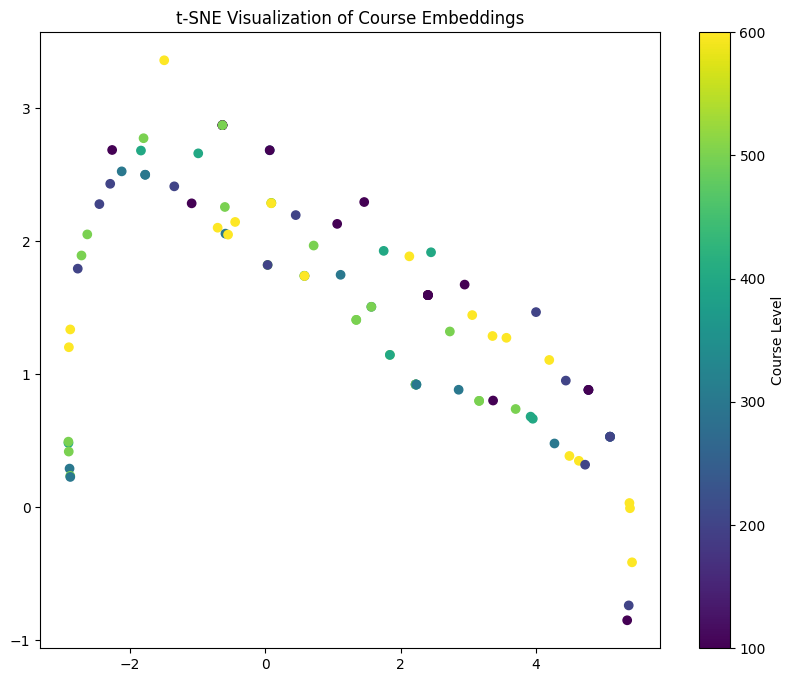

In [49]:
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)


# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=course_catalog_df['Level'], cmap='viridis')
plt.colorbar(scatter, label='Course Level')
plt.title('t-SNE Visualization of Course Embeddings')
plt.show()

In [51]:
# This is some example code to check the quality of the embeddings and make sure that the GNN is working correctly.

def get_similar_courses(course_code, top_k=5):
    course_index = course_catalog_df[course_catalog_df['Code'] == course_code].index[0]
    course_info = course_catalog_df.iloc[course_index]
    course_embedding = embeddings[course_index]
    course_features = data.x[course_index]
    
    # Get department and level of the target course
    target_dept = course_info['Department']
    target_level = course_info['Level']
    
    # Calculate similarities
    embedding_similarities = F.cosine_similarity(course_embedding.unsqueeze(0), embeddings)
    feature_similarities = F.cosine_similarity(course_features.unsqueeze(0), data.x)
    
    # Combine similarities
    similarities = 0.7 * embedding_similarities + 0.3 * feature_similarities
    
    # Apply department and level filters
    dept_mask = course_catalog_df['Department'] == target_dept
    level_diff = abs(course_catalog_df['Level'] - target_level)
    level_mask = level_diff <= 100  # Allow courses within 100 levels
    
    # Boost similarities for courses in the same department and similar level
    similarities[dept_mask] += 0.5
    similarities[level_mask] += 0.3
    
    # Get top similar courses
    _, top_indices = similarities.topk(top_k + 1)
    similar_courses = course_catalog_df.iloc[top_indices[1:]]
    
    return similar_courses[['Code', 'Title', 'Department', 'Level']]

# Example usage
example_course = 'PHYS675'
similar_courses = get_similar_courses(example_course)
print(f"Courses similar to {example_course}:")
print(similar_courses)

Courses similar to PHYS675:
       Code                                              Title Department  \
30  PHYS699          "Advanced Topics in Quantum Field Theory"       PHYS   
7   PHYS679      "Advanced Quantum Mechanics and Applications"       PHYS   
51  PHYS614  "Theoretical Physics: Quantum Field Theory and...       PHYS   
11  PHYS449               "Quantum Mechanics and Applications"       PHYS   
66  PHYS207  "Modern Physics: Quantum Mechanics and Special...       PHYS   

    Level  
30    600  
7     600  
51    600  
11    400  
66    200  


In [38]:
import torch
import torch.nn as nn
import math
import logging 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

# Create Positional Encoder
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

# Create encoder for course embeddings and student data
# This general architecture can be used for any relationship embeddings and supplemental feature set
class TransformerEncoderForStudentAndCourses(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=4*d_model, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_projection = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, src):
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.output_projection(output)
        return self.layer_norm(output)

In [40]:
def preprocess_student_data(student_data):
    # Select relevant features 
    features = ['GPA', 'Total Credits', 'Academic Standing', 'High School GPA', 
                'SAT Score', 'ACT Score', 'Attendance Rate', 'Assignment Completion Rate', 
                'Average Study Hours/Week', 'Work Hours/Week', 'Gender', 'Ethnicity', 
                'First Generation College', 'Preferred Learning Style']
    
    # Split into numerical and categorical features
    numerical_features = ['GPA', 'Total Credits', 'High School GPA', 'SAT Score', 'ACT Score', 
                          'Attendance Rate', 'Assignment Completion Rate', 
                          'Average Study Hours/Week', 'Work Hours/Week']
    categorical_features = ['Academic Standing', 'Gender', 'Ethnicity', 
                            'First Generation College', 'Preferred Learning Style']
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Fill NaN values with mean for numerical features and mode for categorical features
    student_data[numerical_features] = student_data[numerical_features].fillna(student_data[numerical_features].mean())
    for feature in categorical_features:
        student_data[feature] = student_data[feature].fillna(student_data[feature].mode()[0])
    
    # Fit + transform the data
    X = preprocessor.fit_transform(student_data[features])
    
    return X, preprocessor

# Load and preprocess student data
student_data = pd.read_csv('Data/student_data.csv')
X_student, student_preprocessor = preprocess_student_data(student_data)

# Convert to PyTorch tensor
X_student_tensor = torch.tensor(X_student.toarray() if hasattr(X_student, "toarray") else X_student, dtype=torch.float32)

# Initialize TransformerEncoderForStudentAndCourses
input_dim = X_student_tensor.shape[1] + embeddings.shape[1]  # student features + course embeddings
d_model = 256  #  you can adjust this to whatever fits your data best
nhead = 8  # Number of attention heads
num_layers = 3  # Number of transformer layers
transformer_encoder = TransformerEncoderForStudentAndCourses(input_dim, d_model, nhead, num_layers)


c:\Users\Ethan\anaconda3\envs\sled_env\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [41]:
def get_student_and_course_encoding(student_features, course_embedding):
    with torch.no_grad():
        # sanity check both inputs are 2D tensors
        student_features = student_features.unsqueeze(0) if student_features.dim() == 1 else student_features
        course_embedding = course_embedding.unsqueeze(0) if course_embedding.dim() == 1 else course_embedding
        
        # Combine student features and course embeddings
        combined_input = torch.cat((student_features, course_embedding), dim=1)
        # Add sequence length dimension
        combined_input = combined_input.unsqueeze(1)
        encoding = transformer_encoder(combined_input)
        logging.info(f"Combined encoding shape: {encoding.shape}")
        return encoding.squeeze(1)

# This function 
def recommend_courses_for_student(student_id, top_k=5):
    logging.info(f"Generating recommendations for student {student_id}")

    # Get student features and information
    student_index = student_data[student_data['Student ID'] == student_id].index[0]
    student_features = X_student_tensor[student_index]
    student_info = student_data.iloc[student_index]
    student_major = student_info['Major']
    student_gpa = student_info['GPA']

    logging.info(f"Student features shape: {student_features.shape}")
    logging.info(f"Student features (first few): {student_features[:5]}")
    logging.info(f"Student Major: {student_major}")
    logging.info(f"Student GPA: {student_gpa}")

    # Get current courses
    current_courses = student_info['Current Courses'].split('|')
    
    # Get academic plan courses
    academic_plan = student_info['Academic Plan'].split('|')
    
    excluded_courses = current_courses + academic_plan

    logging.info(f"Student's current courses: {current_courses}")
    logging.info(f"Student's academic plan: {academic_plan}")

    # Get combined encoding for student and all courses
    combined_encodings = []
    for course_embedding in embeddings:
        combined_encoding = get_student_and_course_encoding(student_features, course_embedding)
        combined_encodings.append(combined_encoding)
    combined_encodings = torch.stack(combined_encodings)

    # Calculate similarities
    similarities = []
    for i, course in enumerate(course_catalog_df.itertuples()):
        base_similarity = F.cosine_similarity(combined_encodings[i], combined_encodings[i], dim=1).item()
        major_bonus = 0.1 if student_major == course.Department else 0
        similarity = base_similarity + major_bonus
        similarities.append(similarity)

    # Sort courses by similarity
    course_similarities = list(zip(course_catalog_df.index, similarities))
    course_similarities.sort(key=lambda x: x[1], reverse=True)

    logging.info(f"Similarity scores range: [{min(similarities):.4f}, {max(similarities):.4f}]")

    recommended_courses = []
    departments = set()
    for index, similarity in course_similarities:
        course = course_catalog_df.iloc[index]
        course_code = str(course['Code'])
        course_title = str(course['Title'])
        course_dept = str(course['Department'])
        course_difficulty = float(course['Difficulty Rating'])

        # Check exclusion criteria
        if (course_code in excluded_courses or
            course_difficulty > student_gpa + 0.5 or
            not meets_prerequisites(student_id, course_code) or
            (course_dept in departments and len(departments) >= 3)):
            continue

        recommended_courses.append({
            'Code': course_code,
            'Title': course_title,
            'Department': course_dept,
            'Similarity': similarity,
            'Difficulty': course_difficulty
        })
        departments.add(course_dept)

        logging.info(f"Recommended course: {course_code} - {course_title} (Dept: {course_dept}, Similarity: {similarity:.4f}, Difficulty: {course_difficulty:.2f})")

        if len(recommended_courses) == top_k:
            break

    # If we don't have enough recommendations, we can relax the department diversity constraint
    if len(recommended_courses) < top_k:
        for index, similarity in course_similarities:
            if len(recommended_courses) == top_k:
                break
            course = course_catalog_df.iloc[index]
            course_code = str(course['Code'])
            course_title = str(course['Title'])
            course_dept = str(course['Department'])
            course_difficulty = float(course['Difficulty Rating'])

            if (course_code in excluded_courses or
                course_difficulty > student_gpa + 0.5 or
                not meets_prerequisites(student_id, course_code) or
                any(rc['Code'] == course_code for rc in recommended_courses)):
                continue

            recommended_courses.append({
                'Code': course_code,
                'Title': course_title,
                'Department': course_dept,
                'Similarity': similarity,
                'Difficulty': course_difficulty
            })
            logging.info(f"Additional recommended course: {course_code} - {course_title} (Dept: {course_dept}, Similarity: {similarity:.4f}, Difficulty: {course_difficulty:.2f})")

    return recommended_courses

def meets_prerequisites(student_id, course_code):
    student_info = student_data[student_data['Student ID'] == student_id].iloc[0]
    current_courses = set(student_info['Current Courses'].split('|'))
    academic_plan = set(student_info['Academic Plan'].split('|'))
    student_courses = current_courses.union(academic_plan)
    
    prerequisites = course_catalog_df[course_catalog_df['Code'] == course_code]['Prerequisites'].iloc[0]
    if pd.isna(prerequisites):
        return True
    return set(prerequisites.split('|')).issubset(student_courses)

In [43]:
# Training function for the Transformer Encoder
def train_transformer_encoder():
    optimizer = torch.optim.Adam(transformer_encoder.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    num_epochs = 100
    for epoch in range(num_epochs):
        total_loss = 0
        for i, student in enumerate(X_student_tensor):
            try:
                # Get current courses for the student
                current_courses = student_data.iloc[i]['Current Courses'].split('|')
                
                # Get average embedding of current courses
                course_indices = [course_catalog_df[course_catalog_df['Code'] == course].index[0] 
                                  for course in current_courses 
                                  if course in course_catalog_df['Code'].values]
                if not course_indices:
                    continue
                target_embedding = embeddings[course_indices].mean(dim=0)
                
                # Forward pass
                combined_encoding = get_student_and_course_encoding(student, target_embedding)
                loss = criterion(combined_encoding.squeeze(), target_embedding)
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            except Exception as e:
                print(f"Error processing student {i}: {str(e)}")
                continue
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

# Train the Transformer Encoder
train_transformer_encoder()


# Example usage
student_id = 'S631127'
recommended_courses = recommend_courses_for_student(student_id)
print(f"\nRecommended courses for student {student_id}:")
for course in recommended_courses:
    print(f"{course['Code']} - {course['Title']} (Similarity: {course['Similarity']:.4f})")

Epoch [10/100], Loss: 0.0000
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000

Recommended courses for student S631127:
BIO218 - "Ecology and Conservation Biology" (Similarity: 1.1000)
BIO159 - "Introduction to Cellular Biology" (Similarity: 1.1000)
CS111 - "Introduction to Computer Science Fundamentals" (Similarity: 1.0000)
CS262 - "Web Development Fundamentals" (Similarity: 1.0000)
PHYS100 - "Principles of Physics: Mechanics and Motion" (Similarity: 1.0000)
